In [1]:
# script to make selection plots in AN/presentations


import ROOT as rt
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree


import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi
import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
a= tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2



# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()
data_year = 'full'

v1 = 'V1p17'


v2 = '/v5/v163/'


data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/Data2018/'+v2+'/normalized/'




if data_year == 2016:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'
elif data_year == 2017:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'
elif data_year == 2018:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
else: #2016, 2017, 2018AB
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

decay = 'dddd'
mass = [  '7', '15', '40','55']
ctaus  = ['100','1000','10000','100000']
# ctaus  = ['1000']
for ct in ctaus:
    for m in mass:
        v2 = '/v1/v163'
        mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/MC_all'+v2+'/normalized/'
        fpath[decay+'_m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

# v2 = '/v2/v162'
# mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/MC_Fall18'+v2+'/normalized/'
# decay = 'PiPlusPiMinus'
# m_ct = ['ms0p4_pl10',  'ms0p4_pl50',  'ms1p0_pl125', 'ms1p0_pl25',  'ms2p0_pl250', 'ms2p0_pl50', 'ms4p0_pl100', 'ms4p0_pl500', ]
# for ele in m_ct:
    
#     fpath[decay+'_'+ele] = mc_path + 'ggH_HToSS_STo'+decay+'_'+ele+'_1pb_weighted.root'


NEvents = {}
for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print("NEvents",NEvents[k])
    # 22743688.0


data /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018//v5/v163//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root
NEvents 22763250.0
dddd_m7ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-100_137000pb_weighted.root
NEvents 103756430.0
dddd_m15ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-15_ctau-100_137000pb_weighted.root
NEvents 102732904.0
dddd_m40ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-40_ctau-100_137000pb_weighted.root
NEvents 105194904.0
dddd_m55ctau100 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-55_ctau-100_137000pb_weighted.root
NE

# load variables

In [9]:

JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

cut_based = True
cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}

nCscClusters = {}
selections_cluster = {}
sel_cluster = {}
sel_jetveto = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}
a = {}
b = {}
c = {}
d = {}
sel_ev = {}
cluster_index = ''
nRings = {}
cscRechitClusterJetVetoPt = {}
cscClusterSize = {}
cscRechitClusterTime = {}
cscRechitClusterTimeSpread = {}
cscRechitClusterDphi = {}
cscRechitClusterMe11Ratio = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
cscRechitClusterMuonVetoGlobal = {}
cscRechitClusterGlobalMuonVetoPt = {}
cscRechitClusterMuonVetoPt = {}
cscRechitClusterTimeSpreadWeightedAll = {}
dtRechitClusterAvgStation = {}
cscRechitClusterAvgStation = {}
clusterDphi = {}
cscRechitClusterAvgStation = {}
dtRechitClusterJetVetoPt = {}
dtRechitCluster_match_RPChits_dPhi0p5 = {}
dtRechitClusterDphi = {}
dtRechitClusterMB1Ratio = {}
dtRechitClusterSize = {}
dtRechitClusterMuonVetoLooseId = {}
dtRechitClusterMuonVetoPt = {}
dtRechitClusterAvgStation = {}
dtRechitClusterLooseIdMuonVetoPt = {}
dtRechitClusterMuonVetoLooseId = {} 
deltaEta = {}        
deltaRCluster = {}
dtRechitClusterDphi = {}
dtRechitClusterEta = {}
dtRechitClusterPhi = {}
dtRechitClusterNStation = {}
dtRechitClusterStationRatio = {}
metPhi = {}
nCscClusters = {}
evtNum = {}
runNum = {}
lumiNum = {}
nDtSectors = {}
nDtStations= {}
nDtWheels= {}
nDTRechitsNoiseSec8= {}
nDTRechitsNoiseSec9= {}
nDTRechitsNoiseSec10= {}
nTotalDtNoiseHits = {}
cscRechitClusterTimeSpreadWeighted = {}
cscRechitClusterTimeWeighted = {}
deltaEta = {}
category = 0
#2csc, 2dt, 1csc+1dt
for k, T in tree.items():
#     if not k == 'data' and not k[-4:] == '1000' and not 'Pi' in k:continue
    print(k)
########### SELECTION: CLUSTERS ############
    if k == 'data':sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')>=0
    else: sel_csccluster = np.logical_and(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_minDeltaR')<0.4, \
                                    T.array('cscRechitCluster' + cluster_index + '_match_gLLP_csc'))
    
    if k == 'data':sel_dtcluster = T.array('dtRechitCluster_match_RPChits_dPhi0p5')>=0
    else: sel_dtcluster = np.logical_and(T.array('dtRechitCluster_match_gLLP_dt'), T.array('dtRechitCluster_match_gLLP_minDeltaR')<0.4)

########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)



########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    sel_ev[k] = T.array('METNoMuTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() >= 2)
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 0)
    else:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)    
########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]
   
    
   
    if category == 0:

        cscRechitClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterGlobalMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterMuonVetoGlobal[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoGlobal')[sel_csccluster][sel_ev[k]][:,:]

        cscRechitClusterGlobalMuonVetoPt[k][np.logical_not(cscRechitClusterMuonVetoGlobal[k])] = 0.0
        cscRechitClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,:]

        
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeTotal')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterTimeSpreadWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeighted')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterTimeSpreadWeightedAll[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,:]

        
        cscRechitClusterDphi[k] =  T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterMe11Ratio[k] =  T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterEta[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]]  
        clusterDphi[k] = deltaPhi(T.array('cscRechitClusterPhi')[sel_csccluster][sel_ev[k]][:,0], \
                                         T.array('cscRechitClusterPhi')[sel_csccluster][sel_ev[k]][:,1])
        deltaEta[k] = T.array('cscRechitClusterEta')[sel_csccluster][sel_ev[k]][:,0]-T.array('cscRechitClusterEta')[sel_csccluster][sel_ev[k]][:,1]
        deltaRCluster[k] = deltaR(T.array('cscRechitClusterEta')[sel_csccluster][sel_ev[k]][:,0], T.array('cscRechitClusterPhi')[sel_csccluster][sel_ev[k]][:,0],\
                                  T.array('cscRechitClusterEta')[sel_csccluster][sel_ev[k]][:,1], T.array('cscRechitClusterPhi')[sel_csccluster][sel_ev[k]][:,1])
        nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
        
    elif category == 1:
        dtRechitClusterJetVetoPt[k] = T.array('dtRechitClusterTightJetVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
        
        dtRechitCluster_match_RPChits_dPhi0p5[k] = T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterEta[k] =  T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterPhi[k] =  T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterAvgStation[k] =  T.array('dtRechitClusterAvgStation10')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterDphi[k] =  T.array('dtRechitCluster' + cluster_index + 'MetEENoise_dPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterMB1Ratio[k] = (T.array('dtRechitClusterNSegmentStation1')/T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][:,:]
        
        dtRechitClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterMuonVetoLooseId[k] = T.array('dtRechitClusterMuonVetoLooseId')[sel_dtcluster][sel_ev[k]][:,:]

        dtRechitClusterMuonVetoPt[k][np.logical_not(dtRechitClusterMuonVetoLooseId[k])] = 0.0

        
        clusterDphi[k] = deltaPhi(T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,0], \
                                         T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,1])
        
        
#             sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) #remove if both clusters are 4 stations


        cut = 5
        dtRechitClusterNStation[k] = ((T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int))[sel_dtcluster][sel_ev[k]][:,:]

        
        max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
        min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
        dtRechitClusterStationRatio[k] = (min_station/max_station)[sel_dtcluster][sel_ev[k]][:,:]
        deltaEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,0]-T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,1]
        deltaRCluster[k] = deltaR(T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,0], T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,0],\
                                  T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,1], T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,1])


    else:
        dtRechitClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterLooseIdMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterMuonVetoLooseId[k] = T.array('dtRechitClusterMuonVetoLooseId')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterLooseIdMuonVetoPt[k][np.logical_not(dtRechitClusterMuonVetoLooseId[k])] = 0.0

        dtRechitClusterJetVetoPt[k] = T.array('dtRechitClusterTightJetVetoPt')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterAvgStation[k] = T.array('dtRechitClusterAvgStation10')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,0]
#         dtRechitClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,0]

        cscRechitClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]][:,0]

        cscRechitClusterGlobalMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterMuonVetoGlobal[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoGlobal')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterGlobalMuonVetoPt[k][np.logical_not(cscRechitClusterMuonVetoGlobal[k])] = 0.0
        cscRechitClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterTimeSpreadWeightedAll[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[sel_csccluster][sel_ev[k]][:,0]
        
        cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0]
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeTotal')[sel_csccluster][sel_ev[k]][:,0]

        deltaRCluster[k] = deltaR(dtRechitClusterEta[k], dtRechitClusterPhi[k],cscRechitClusterEta[k], cscRechitClusterPhi[k])
        deltaEta[k] = dtRechitClusterEta[k]-cscRechitClusterEta[k]

#         dtRechitClusterMaxStation[k] = T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,0]
        clusterDphi[k] = deltaPhi(dtRechitClusterPhi[k], cscRechitClusterPhi[k])

        
    weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev[k]]
    nDtSectors[k] = np.sum(np.reshape(T.array('nDTRechitsSector')>=3, (-1,4*5*12)), axis = 1)[sel_ev[k]]
    nDtStations[k] = T.array('nDtStations25')[sel_ev[k]]
    nDtWheels[k] = T.array('nDtWheels25')[sel_ev[k]]

    nTotalDtNoiseHits[k] = (T.array('nDTRechitsSector')[:,0,0,7]+T.array('nDTRechitsSector')[:,0,0,8]+T.array('nDTRechitsSector')[:,0,0,9])[sel_ev[k]]
    nDTRechitsNoiseSec8[k]= T.array('nDTRechitsSector')[:,0,0,7][sel_ev[k]]
    nDTRechitsNoiseSec9[k]= T.array('nDTRechitsSector')[:,0,0,8][sel_ev[k]]
    nDTRechitsNoiseSec10[k] = T.array('nDTRechitsSector')[:,0,0,9][sel_ev[k]]


data
dddd_m7ctau100
dddd_m15ctau100
dddd_m40ctau100
dddd_m55ctau100
dddd_m7ctau1000
dddd_m15ctau1000
dddd_m40ctau1000
dddd_m55ctau1000
dddd_m7ctau10000
dddd_m15ctau10000
dddd_m40ctau10000
dddd_m55ctau10000
dddd_m7ctau100000
dddd_m15ctau100000
dddd_m40ctau100000
dddd_m55ctau100000


# CSC Cluster Plots

data 0.1693548387096774
dddd_m7ctau100 0.9840637450199203
dddd_m15ctau100 1.0
dddd_m7ctau1000 0.7672413793103449
dddd_m15ctau1000 0.8837209302325582
dddd_m40ctau1000 1.0
dddd_m55ctau1000 1.0
dddd_m7ctau10000 1.0
dddd_m15ctau10000 0.5
dddd_m40ctau10000 1.0
dddd_m55ctau10000 1.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potenti

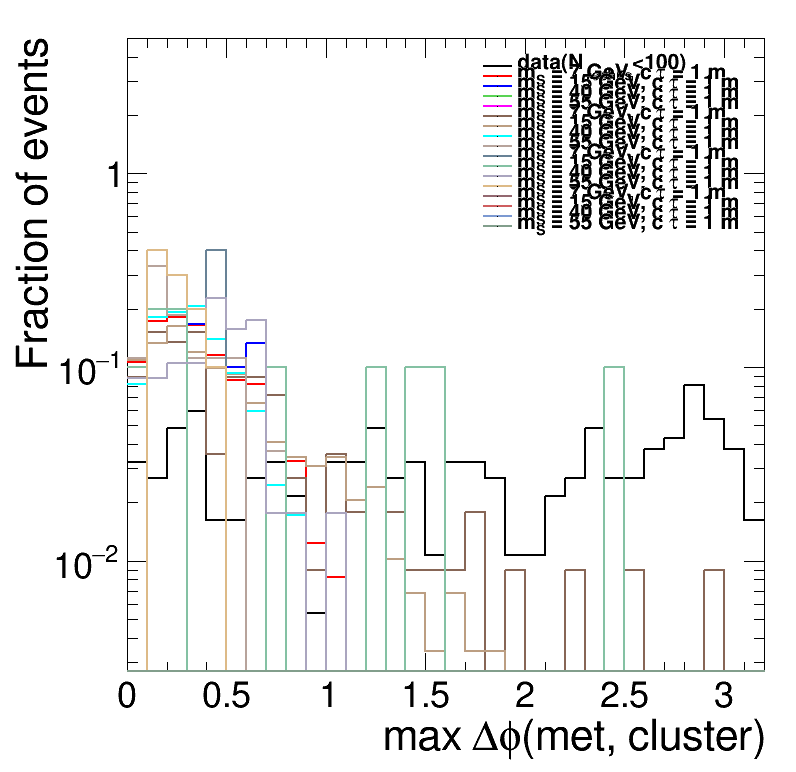

In [13]:
assert(category == 0 or category == 2)




var = [cscRechitClusterTimeWeighted, cscRechitClusterTimeSpreadWeightedAll, cscRechitClusterJetVetoPt, cscRechitClusterGlobalMuonVetoPt, cscRechitClusterDphi, cscRechitClusterMe11Ratio, \
       deltaRCluster, deltaEta, cscRechitClusterEta, cscRechitClusterPhi, cscRechitClusterAvgStation, clusterDphi]
name = ['cscRechitClusterTimeWeighted', 'cscRechitClusterTimeSpreadWeightedAll', 'cscRechitClusterJetVetoPt', 'cscRechitClusterGlobalMuonVetoPt', 'cscRechitClusterDphiMet', 'cscRechitClusterMe11Ratio',\
       'deltaRCluster', 'deltaEta', 'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterAvgStation', 'clusterDphi']

xaxis = ['cluster time [ns]', 'max cluster time spread [ns]', 'max jet veto p_{T} [GeV]','max muon veto p_{T} [GeV]', 'max #Delta#phi(met, cluster)', 'max N_{ME11 hits}/N_{rechits}',\
        '#Delta R(cluster1, cluster2)', '#Delta#eta(cluster1, cluster2)', 'cluster #eta', 'cluster #phi', 'cluster average station', '#Delta#phi(cluster1, cluster2)']

# bins = [ [100,-100,120], [50,0,100], [50,0,500],[50,0,200], [32,0,3.2], [25,0,1.1],[25,0.8,2.5],[30,0,3.2],[35,1,4], [40,0,3.2], [40,0,8], [40,0,5]]

bins = [ [100,-100,120], [50,0,100], [50,0,500],[50,0,200], [32,0,3.2], [22,0,1.1],[40,0,8], [40,0,5], [25,0.8,2.5],[25,0,3.2],[20,1,4], [25,0,3.2]]

setlogy = [1,1,1,1,1,1,1,1,1,1,1,1]

for index in range(len(var)):
    if not index == 4:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.6,0.7,0.80,0.92)

#     leg = rt.TLegend(0.5,0.56,0.75,0.92)

    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
#         if not k[-4:] == '1000' and not k == 'data' and not 'Pi' in k:continue
        if k == 'data':sel_csccluster =  cscClusterSize[k]<1000000
        else: sel_csccluster = cscClusterSize[k]>=100
        if index > 0:sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(cscRechitClusterTimeWeighted[k]<12.5, cscRechitClusterTimeWeighted[k]>-5))
        if index < 8:
            if index > 1 or index == 0: sel_csccluster = np.logical_and(sel_csccluster, cscRechitClusterTimeSpreadWeightedAll[k]<20)
            if index > 2: sel_csccluster = np.logical_and(sel_csccluster, cscRechitClusterJetVetoPt[k]<30)
            if index > 3: sel_csccluster = np.logical_and(sel_csccluster, cscRechitClusterGlobalMuonVetoPt[k]<100)
            if index > 4: sel_csccluster = np.logical_and(sel_csccluster,  np.abs(cscRechitClusterDphi[k])<1.2)
            if index > 5: sel_csccluster = np.logical_and(sel_csccluster,  cscRechitClusterMe11Ratio[k] < 1)
#         sel_csccluster = np.logical_and(sel_csccluster,  np.abs(cscRechitClusterDphi[k])<1.2)
        if index == 11:
            sel_csccluster = np.logical_and(sel_csccluster, cscRechitClusterTimeSpreadWeightedAll[k]<20)
            sel_csccluster = np.logical_and(sel_csccluster,  cscRechitClusterMe11Ratio[k] < 1)
            sel_csccluster = np.logical_and(sel_csccluster, cscRechitClusterJetVetoPt[k]<30)
            sel_csccluster = np.logical_and(sel_csccluster, cscRechitClusterGlobalMuonVetoPt[k]<30)
            

            
        if category == 0:cond = sel_csccluster.sum()==2
        else:cond = sel_csccluster
        if k == 'data':
            cond= np.logical_and(cond, cscClusterSize[k].min()<100)
        if category == 0:
            if index == 5:h[k] = create_TH1D(np.abs(var[index][k][sel_csccluster][cond]).max(), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            if index == 0: h[k] = create_TH1D(np.hstack((var[index][k][sel_csccluster][cond][:,0], var[index][k][sel_csccluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            elif index == 8 or index == 9 or index == 10:h[k] = create_TH1D(np.abs(np.hstack((var[index][k][sel_csccluster][cond][:,0], var[index][k][sel_csccluster][cond][:,1]))), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            elif index == 6 or index == 7 or index == 11:h[k] = create_TH1D(np.abs(var[index][k][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            else: h[k] = create_TH1D(var[index][k][sel_csccluster][cond].max(), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        
            if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<100)')
            elif 'Pi' in k:leg.AddEntry(h[k],k)
            else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')

            h[k].SetLineColor(std_color_list[i])
            if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
            if index == 0:
                h[k].SetMaximum(50)
                h[k].SetMinimum(1e-4)
            elif index == 1:
                h[k].SetMaximum(10)
            elif index == 4 or index == 2:h[k].SetMaximum(5)
            elif index == 5 or index == 6 or index == 7 : 
                h[k].SetMaximum(5)
                h[k].SetMinimum(0.001)
            elif index == 8:
                h[k].SetMaximum(1.5)
                h[k].SetMinimum(0.001)
            elif index == 9:
                h[k].SetMaximum(20)
                h[k].SetMinimum(0.001)          
            elif index == 10:
                h[k].SetMaximum(1.5)
                h[k].SetMinimum(0.001)  
            elif index == 11:
                h[k].SetMaximum(2.5)
                h[k].SetMinimum(0.001)  
            h[k].Draw('hist same')
        
#         if index == 0:print(k, np.count_nonzero(np.logical_and(var[index][k][sel_csccluster][cond].min()>-5, var[index][k][sel_csccluster][cond].max()<12.5))/np.count_nonzero(cond))
#         elif index == 1:print(k, np.count_nonzero(var[index][k][sel_csccluster][cond].max()<20)/np.count_nonzero(cond))                        
#         elif index == 2:
#             print(k, np.count_nonzero(var[index][k][sel_csccluster][cond].max()<30)/np.count_nonzero(cond))
# #             print(k, np.count_nonzero(var[index][k][sel_csccluster]<30)/np.count_nonzero(sel_csccluster))
        if index == 4 and np.count_nonzero(cond)>0:print(k, np.count_nonzero(np.abs(var[index][k][sel_csccluster][cond]).max()<1.2)/np.count_nonzero(cond))
#         elif index == 6:print(k, np.count_nonzero(np.abs(var[index][k][sel_csccluster][cond]).max()<1)/np.count_nonzero(cond))
# #         elif index == 9:
# #             print(k, np.count_nonzero(np.abs(var[index][k][sel_csccluster][cond]).max()<100)/np.count_nonzero(cond))
# #             print(k, np.count_nonzero(np.abs(cscRechitClusterMuonVetoPt[k][sel_csccluster][cond]).max()<20)/np.count_nonzero(cond))
# #             print(k, np.count_nonzero(np.abs(var[index][k][sel_csccluster][cond]).max()<100)/np.count_nonzero(np.abs(cscRechitClusterMuonVetoPt[k][sel_csccluster][cond]).max()<20))
            
# #             print(k, np.count_nonzero(np.abs(var[index][k][sel_csccluster])<100)/np.count_nonzero(cond))
# #             print(k, np.count_nonzero(np.abs(cscRechitClusterMuonVetoPt[k][sel_csccluster])<20)/np.count_nonzero(cond))
# #             print(k, np.count_nonzero(np.abs(var[index][k][sel_csccluster])<100)/np.count_nonzero(np.abs(cscRechitClusterMuonVetoPt[k][sel_csccluster])<20))

#         print(k, np.count_nonzero(np.logical_and(np.abs(clusterDphi[k])<2.4, np.abs(deltaRCluster[k])<2.)[cond])/len(deltaEta[k][cond]))
#         print(k, np.count_nonzero(np.logical_and(np.abs(clusterDphi[k])<2.4, np.abs(deltaEta[k])<1.5)[cond])/len(deltaEta[k][cond]))
        
    leg.Draw()
    c.SetRightMargin(0.04)


    if setlogy[index]: c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".png")
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".pdf")
#     c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".C")




# DT Cluster Plots

data 0.05825242718446602
dddd_m7ctau100 0.9925925925925926
dddd_m15ctau100 1.0
dddd_m7ctau1000 0.8015267175572519
dddd_m15ctau1000 0.9024856596558317
dddd_m40ctau1000 0.9977272727272727
dddd_m55ctau1000 1.0
dddd_m7ctau10000 0.5714285714285714
dddd_m15ctau10000 0.6470588235294118
dddd_m40ctau10000 0.9881656804733728
dddd_m55ctau10000 1.0
dddd_m40ctau100000 1.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potenti

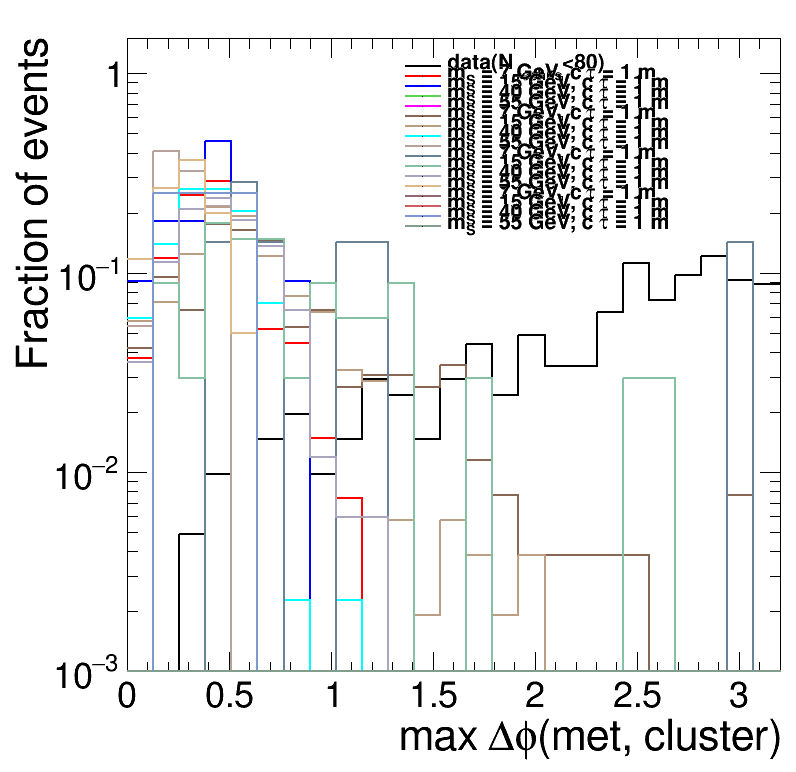

In [8]:
assert(category >= 1)



var = [dtRechitClusterJetVetoPt, dtRechitClusterMuonVetoPt, dtRechitClusterDphi, dtRechitClusterMB1Ratio,\
        deltaRCluster, dtRechitClusterEta, dtRechitClusterPhi, dtRechitClusterAvgStation, clusterDphi, dtRechitClusterNStation,dtRechitClusterStationRatio]

name = ['dtRechitClusterJetVetoPt', 'dtRechitClusterMuonVetoPt', 'dtRechitClusterDphi_met', 'dtRechitClusterMB1Ratio',\
               'deltaRCluster',  'dtRechitClusterEta', 'dtRechitClusterPhi', 'dtRechitClusterAvgStation', 'clusterDphi','dtRechitClusterNStation','dtRechitClusterStationRatio']


xaxis = ['max jet veto p_{T} [GeV]', 'max muon veto p_{T} [GeV]', 'max #Delta#phi(met, cluster)', 'max N_{MB1 hits}/N_{rechits}',\
          '#Delta R(cluster1, cluster2)', 'cluster #eta', 'cluster #phi', 'cluster average station', '#Delta#phi(cluster1, cluster2)','N_{station}','N_{hit min station}/N_{hit max station}']




bins = [ [50,0,500],[40,0,200], [25,0,3.2], [50,0,1.1], [25,0,3], [25,0.0,1.2],[25,0,3.2],[20,1,4], [25,0,3.2],[5,0,5],[25,0,1]]
setlogy = [1,1,1,1,1,1,0,0,1,1,1,1]



for index in range(len(var)):
    if not index == 2:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.7,0.75,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
#         if not k[-4:] == '1000' and not k == 'data':continue
        if k == 'data':sel_dtcluster =  dtRechitClusterSize[k]<80
        else: sel_dtcluster = dtRechitClusterSize[k]>=80
        if index <= 4:
            if index > 0: sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterJetVetoPt[k]<50)
            if index > 1: sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterMuonVetoPt[k]<10)
            if index > 2: sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(dtRechitClusterDphi[k])<1)
        elif index == 8:
            sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterJetVetoPt[k]<50)
            sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterMuonVetoPt[k]<10)
        elif index == 9 or index == 10:
            sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterJetVetoPt[k]<50)
            sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterMuonVetoPt[k]<10)
            sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(dtRechitClusterDphi[k])<1)
#             if index == 10: sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(dtRechitClusterNStation[k])==4)
        if category == 1: 
            cond = sel_dtcluster.sum()==2
            if index < 4:h[k] = create_TH1D(np.abs(var[index][k][sel_dtcluster][cond]).max(), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            elif index == 4 or index == 8:h[k] = create_TH1D(np.abs(var[index][k][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            elif index == 10: h[k] = create_TH1D(np.abs(np.hstack((var[index][k][sel_dtcluster][cond][:,0][dtRechitClusterNStation[k][sel_dtcluster][cond][:,0]==4],\
                                                                   var[index][k][sel_dtcluster][cond][:,1][dtRechitClusterNStation[k][sel_dtcluster][cond][:,1]==4]))), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])

            else: h[k] = create_TH1D(np.abs(np.hstack((var[index][k][sel_dtcluster][cond][:,0], var[index][k][sel_dtcluster][cond][:,1]))), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            h[k].SetLineColor(std_color_list[i])
            if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())

            if index == 4:h[k].SetMaximum(5)
            elif index == 5:h[k].SetMaximum(2)
            elif index == 9:h[k].SetMaximum(20)
            else: h[k].SetMaximum(1.5)
            h[k].SetMinimum(0.001)
            h[k].Draw('hist same')
        
            if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<80)')
            else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')
            if np.count_nonzero(cond)>0:
                print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<1)/np.count_nonzero(cond))
#         if index == 0:
#             if category == 1: print(k, np.count_nonzero(var[index][k][sel_dtcluster][cond].max()<50)/np.count_nonzero(cond))
#             else: print(k, np.count_nonzero(var[index][k][sel_dtcluster]<50)/np.count_nonzero(sel_dtcluster))
#         elif index == 1:
# #             print(k, np.count_nonzero(var[index][k][sel_dtcluster][cond].max()<10)/np.count_nonzero(cond))
#             print(k, np.count_nonzero(var[index][k][sel_dtcluster]<10)/np.count_nonzero(sel_dtcluster))
#         elif index == 2:print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<1)/np.count_nonzero(cond))
#         elif index == 3:print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<0.9)/np.count_nonzero(cond))
    leg.Draw()
#     c.SetRightMargin(0.2)


    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'+v2+'/'
    if not os.path.exists(plot_path):os.makedirs(plot_path)
#     c.SaveAs(plot_path+'dtdt_'+name[index]+".png")
#     c.SaveAs(plot_path+'dtdt_'+name[index]+".pdf")
#     c.SaveAs(plot_path+'dtdt_'+name[index]+".C")




# DT-CSC plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots/v2/v162/dtcsc_clusterDphi.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots/v2/v162/dtcsc_clusterDphi.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots/v2/v162/dtcsc_clusterDphi.C has been generated


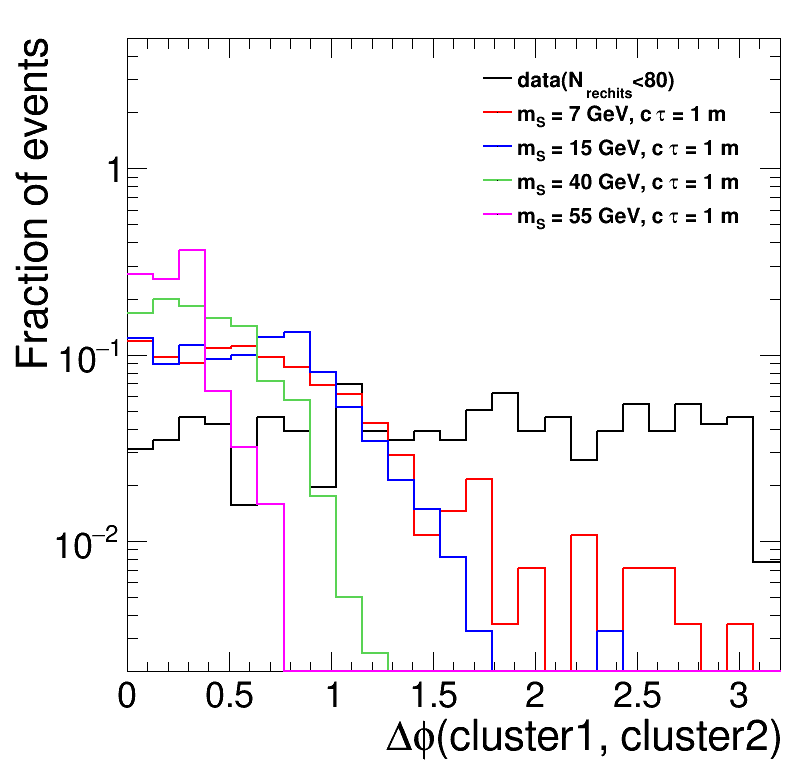

In [22]:
assert(category==2)

var = [clusterDphi, deltaRCluster, deltaEta, dtRechitClusterEta, dtRechitClusterPhi, dtRechitClusterAvgStation,\
      cscRechitClusterEta, cscRechitClusterPhi, cscRechitClusterAvgStation]
name = ['clusterDphi', 'deltaRCluster', 'deltaEta', 'dtRechitClusterEta', 'dtRechitClusterPhi', 'dtRechitClusterAvgStation',\
      'cscRechitClusterEta', 'cscRechitClusterPhi', 'cscRechitClusterAvgStation']
xaxis = ['#Delta#phi(cluster1, cluster2)', '#Delta R(cluster1, cluster2)', '#Delta#eta(cluster1, cluster2)',\
         'cluster #eta', 'cluster #phi', 'cluster average station',\
         'cluster #eta', 'cluster #phi', 'cluster average station']



bins = [  [25,0,3.2], [40,0,4], [40,0,5],[20,0,1.2],[25,0,3.2],[20,1,4],[25,0.8,2.5],[25,0,3.2],[20,1,4]]
setlogy = [1,1,1,1,1,1,1,1,1]



for index in range(len(var)):
    if not index == 0:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.6,0.7,0.8,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
#         if not k[-4:] == '1000' and not k == 'data':continue
        if k == 'data':cond =  np.logical_and(cscClusterSize[k]<100, dtRechitClusterSize[k]<80)
        else: cond =  cscClusterSize[k]>=50
        if index == 0:
            cond = np.logical_and(cond, dtRechitClusterJetVetoPt[k]<50)
            cond = np.logical_and(cond, dtRechitClusterMuonVetoPt[k]<10)
            
            cond =  np.logical_and(cond, cscRechitClusterTimeWeighted[k]<12.5)
            cond = np.logical_and(cond,cscRechitClusterTimeWeighted[k]>-5)
     
            cond = np.logical_and(cond, cscRechitClusterTimeSpreadWeightedAll[k]<20)
            cond = np.logical_and(cond, cscRechitClusterMe11Ratio[k] < 1)
            cond = np.logical_and(cond, cscRechitClusterJetVetoPt[k]<30)
            cond = np.logical_and(cond, cscRechitClusterGlobalMuonVetoPt[k]<100)

            
        if category == 0:cond = sel_csccluster.sum()==2
            
#         h[k] = create_TH1D(np.abs(var[index][k][np.abs(clusterDphi[k])<2.2]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        h[k] = create_TH1D(np.abs(var[index][k][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])

        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())

        if index == 4 or index == 0:h[k].SetMaximum(5)
        else: h[k].SetMaximum(15)
        h[k].SetMinimum(0.002)
        h[k].Draw('hist same')

        if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<80)')
        elif 'Pi' in k:leg.AddEntry(h[k],k)
        else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')
#         print(k, np.count_nonzero(np.logical_and(np.abs(clusterDphi[k])<2.2, np.abs(deltaRCluster[k])<2.5))/len(deltaEta[k][np.abs(clusterDphi[k])<2.2]))
#         print(k, np.count_nonzero(np.logical_and(np.abs(clusterDphi[k])<2.2, np.abs(deltaEta[k])<2.5))/len(deltaEta[k][np.abs(clusterDphi[k])<2.2]))
    leg.Draw()
#     c.SetRightMargin(0.2)


    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'+v2+'/'
    if not os.path.exists(plot_path):os.makedirs(plot_path)
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".png")
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".pdf")
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".C")


# DT Noise Hits

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


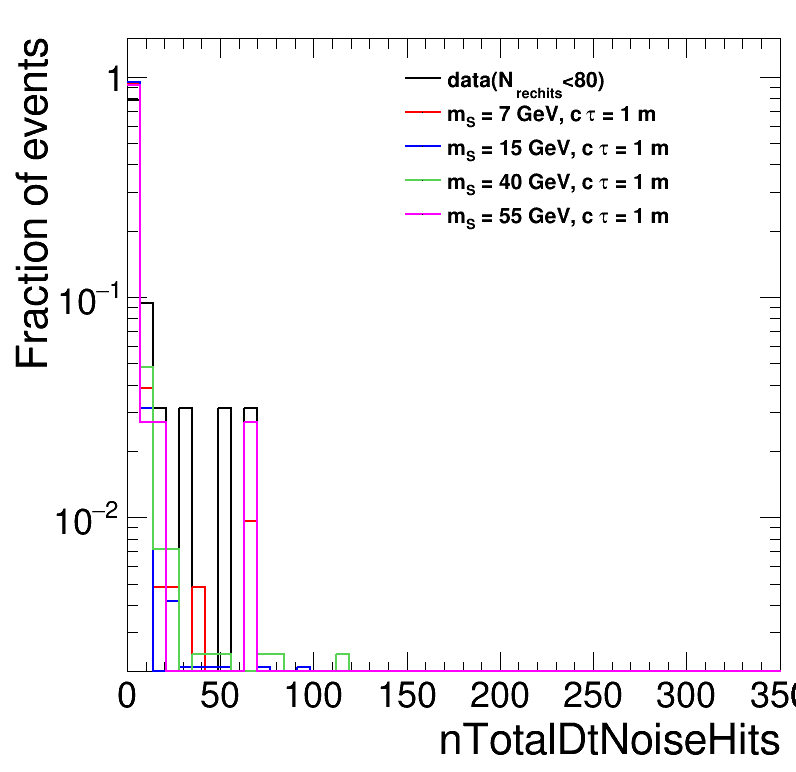

In [29]:
assert(category == 1)


var = [nTotalDtNoiseHits, nDTRechitsNoiseSec8, nDTRechitsNoiseSec9, nDTRechitsNoiseSec10]

name = ['nTotalDtNoiseHits', 'nDTRechitsNoiseSec8', 'nDTRechitsNoiseSec9', 'nDTRechitsNoiseSec10']
xaxis = ['nTotalDtNoiseHits', 'nDTRechitsNoiseSec8', 'nDTRechitsNoiseSec9', 'nDTRechitsNoiseSec10']

bins = [ [50,0,350]]*4


for index in range(len(var)):
    if not index == 0:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.7,0.75,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
        if not k[-4:] == '1000' and not k == 'data':continue
        if k == 'data':sel_dtcluster =  dtClusterSize[k]<80
        else: sel_dtcluster = dtClusterSize[k]>=80
        sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitCluster_match_RPChits_dPhi0p5[k]>=1)
        sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterJetVetoPt[k]<50)
        sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(dtRechitClusterDphi[k])<1.2)
        cond = sel_dtcluster.sum()==2

        h[k] = create_TH1D(np.abs(var[index][k][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        #     print(k, np.count_nonzero(var[index][k][sel_csccluster][cond].max()<30)/np.count_nonzero(cond))
        if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<80)')
        else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')

#         if index == 0:print(k, np.count_nonzero(var[index][k][sel_dtcluster][cond].min()>=1)/np.count_nonzero(cond))
#         elif index == 1:print(k, np.count_nonzero(var[index][k][sel_dtcluster][cond].max()<50)/np.count_nonzero(cond))
#         elif index == 2:print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<1)/np.count_nonzero(cond))
#         elif index == 3:print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<0.9)/np.count_nonzero(cond))

        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())

        if index == 4:h[k].SetMaximum(5)
        else: h[k].SetMaximum(1.5)
        h[k].SetMinimum(0.002)
        h[k].Draw('hist same')
    leg.Draw()
#     c.SetRightMargin(0.2)


    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'
#     c.SaveAs(plot_path+v2+'/'+name[index]+".png")
#     c.SaveAs(plot_path+v2+'/'+name[index]+".pdf")
#     c.SaveAs(plot_path+v2+'/'+name[index]+".C")



